In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
EVAL_DIRS = [
    "images"
]
csv_file = 'annotations.csv'

BASELINE_CKPT = "final_model.pth"
FINETUNED_CKPT = "finetuned_model.pth"

NUM_CLASSES = 2
BATCH_SIZE = 1
NUM_WORKERS = 0
SCORE_THRESH = 0.5
IOU_THRESH = 0.5

print("device:", device)
print("eval dirs:", EVAL_DIRS)

device: cuda
eval dirs: ['images']


In [3]:
def box_iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b

    inter_x1 = max(ax1, bx1)
    inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2)
    inter_y2 = min(ay2, by2)

    inter_w = max(0.0, inter_x2 - inter_x1)
    inter_h = max(0.0, inter_y2 - inter_y1)
    inter = inter_w * inter_h

    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    union = area_a + area_b - inter

    if union <= 0.0:
        return 0.0

    return inter / union


def evaluate_metrics(model, data_loader, device, score_thresh=0.5, iou_thresh=0.5):
    model.eval()
    ious = []
    detected = 0
    total = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                gt_boxes = target["boxes"].cpu().numpy()
                if gt_boxes.shape[0] == 0:
                    continue

                total += 1

                scores = output["scores"].detach().cpu().numpy()
                boxes = output["boxes"].detach().cpu().numpy()

                keep = scores >= score_thresh
                if keep.sum() == 0:
                    ious.append(0.0)
                    continue

                scores_keep = scores[keep]
                boxes_keep = boxes[keep]

                idx = scores_keep.argmax()
                pred = boxes_keep[idx]
                gt = gt_boxes[0]

                iou = box_iou(pred, gt)
                ious.append(iou)

                if iou >= iou_thresh:
                    detected += 1

    avg_iou = float(np.mean(ious)) if len(ious) > 0 else 0.0
    det_rate = detected / max(1, total)
    return avg_iou, det_rate


In [4]:
class NumberPlateDataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            images_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        # Get the row corresponding to the idx
        row = self.data_frame.iloc[idx]
        img_name = row['filename']  
        
        # Load image
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        # Get bounding box coordinates (e.g., x_min, y_min, x_max, y_max)
        bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]
        bbox = torch.tensor(bbox, dtype=torch.float32).unsqueeze(0)   #1 class

        # For transfer learning, if you have only one class (number plate), you could use label 1.
        # Adjust accordingly if you have more classes.
        labels = torch.tensor([1], dtype=torch.int64)
        
        # Apply any transformations to the image (if provided)
        if self.transform:
            image = self.transform(image)
        
        #target dictionary
        target = {
            'boxes': bbox,
            'labels': labels
        }
        
        return image, target

transform = T.Compose([T.ToTensor()])

def collate_fn(batch):
    images = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    return images, targets


eval_transform = T.Compose([T.ToTensor()])


def make_loader(images_dir):
    dataset = NumberPlateDataset(csv_file, images_dir, transform)
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=NUM_WORKERS,
        pin_memory=True if device.type == "cuda" else False,
    )
    return dataset, loader


"dataset_ready"


'dataset_ready'

In [5]:
def build_model(num_classes, ckpt_path):
    model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if ckpt_path is not None and os.path.exists(ckpt_path):
        state_dict = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(state_dict, strict=False)

    model.to(device)
    model.eval()
    return model


baseline_model = build_model(NUM_CLASSES, BASELINE_CKPT)
finetuned_model = build_model(NUM_CLASSES, FINETUNED_CKPT)

baseline_model.eval()
finetuned_model.eval()

"models_ready"


'models_ready'

In [6]:
results = []

for images_dir in EVAL_DIRS:
    if not os.path.isdir(images_dir):
        print(f"[skip] {images_dir} not found")
        continue

    dataset, loader = make_loader(images_dir)

    baseline_iou, baseline_det = evaluate_metrics(
        baseline_model,
        loader,
        device,
        score_thresh=SCORE_THRESH,
        iou_thresh=IOU_THRESH,
    )

    finetuned_iou, finetuned_det = evaluate_metrics(
        finetuned_model,
        loader,
        device,
        score_thresh=SCORE_THRESH,
        iou_thresh=IOU_THRESH,
    )

    results.append(
        {
            "dir": images_dir,
            "n_images": len(dataset),
            "baseline_iou": baseline_iou,
            "baseline_det": baseline_det,
            "finetuned_iou": finetuned_iou,
            "finetuned_det": finetuned_det,
        }
    )

    print("==========", images_dir, "==========")
    print("num images:", len(dataset))
    print("Baseline  avg IoU:", baseline_iou)
    print("Baseline  det rate:", baseline_det)
    print("Finetuned avg IoU:", finetuned_iou)
    print("Finetuned det rate:", finetuned_det)

results


========== images ==========
num images: 91
Baseline  avg IoU: 0.27260865909712656
Baseline  det rate: 0.37362637362637363
Finetuned avg IoU: 0.6673545188956208
Finetuned det rate: 0.7692307692307693


[{'dir': 'images',
  'n_images': 91,
  'baseline_iou': 0.27260865909712656,
  'baseline_det': 0.37362637362637363,
  'finetuned_iou': 0.6673545188956208,
  'finetuned_det': 0.7692307692307693}]

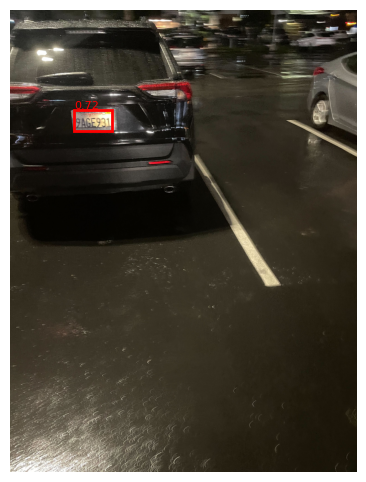

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

@torch.no_grad()
def visualize_prediction_on_path(model, img_path, transform=None, score_thresh=0.5):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    if transform is not None:
        image = transform(img)
    else:
        image = T.ToTensor()(img)
    model_input = [image.to(device)]
    outputs = model(model_input)
    output = outputs[0]
    img_np = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(img_np)
    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()
    for (xmin, ymin, xmax, ymax), s in zip(boxes, scores):
        if s < score_thresh:
            continue
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, f"{s:.2f}", color="r", fontsize=8)
    plt.axis("off")
    plt.show()


# test_image_path = "./images/IMG_1882.jpg"
test_image_path = "./images/IMG_1896.jpg"
visualize_prediction_on_path(baseline_model, test_image_path, transform=transform, score_thresh=0.5)
